# `U-Net` for Semantic Segmentation to Detect Drivable Area

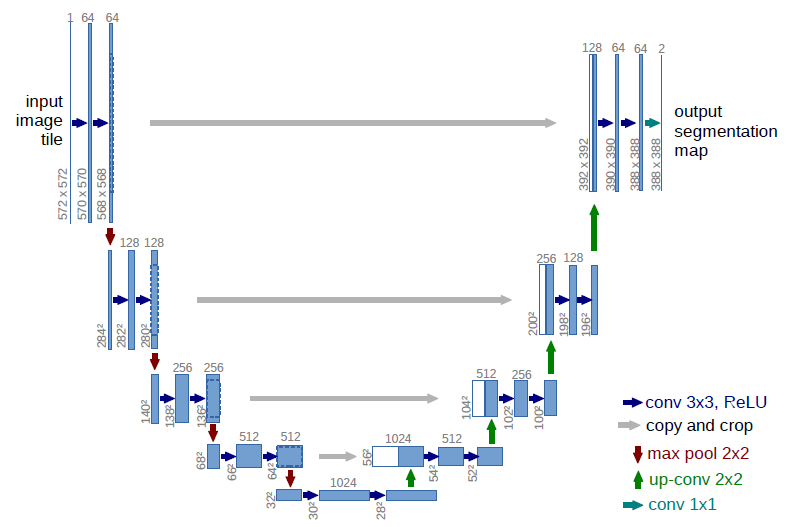

[Image reference](https://arxiv.org/abs/1505.04597)

## Imports

- Transfer Learning -> import "segmentation_models_pytorch" library ([accessible here](https://github.com/qubvel/segmentation_models.pytorch))


In [5]:
# basic imports
import random
import numpy as np
from tqdm import tqdm

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

In [7]:
# load images and label data
images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

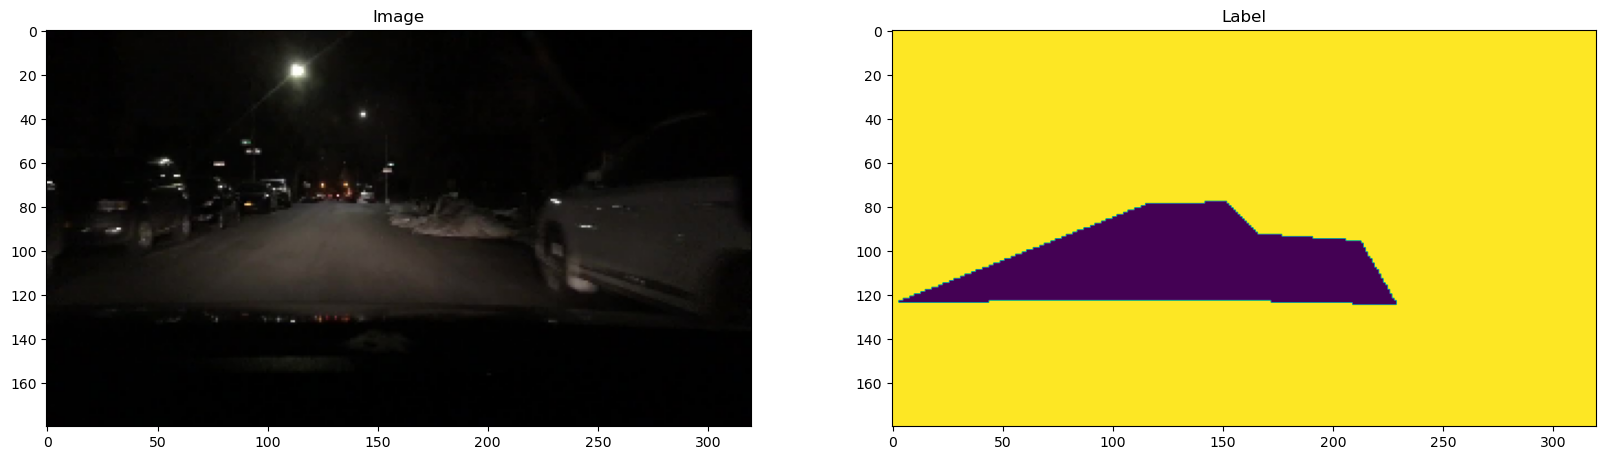

In [8]:
# plot sample image
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
ax0.imshow(images[458])    # random image number
ax0.set_title("Image")
ax1.imshow(labels[458])
ax1.set_title("Label")
plt.show()

### Class label to standard color maps

In [9]:
# Constants for Standard color mapping
# reference : https://github.com/bdd100k/bdd100k/blob/master/bdd100k/label/label.py
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (171, 44, 236)),        # red
             Label("alternative", 1, (86, 211, 19)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color = \n {train_id_to_color}")

train_id_to_color = 
 [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


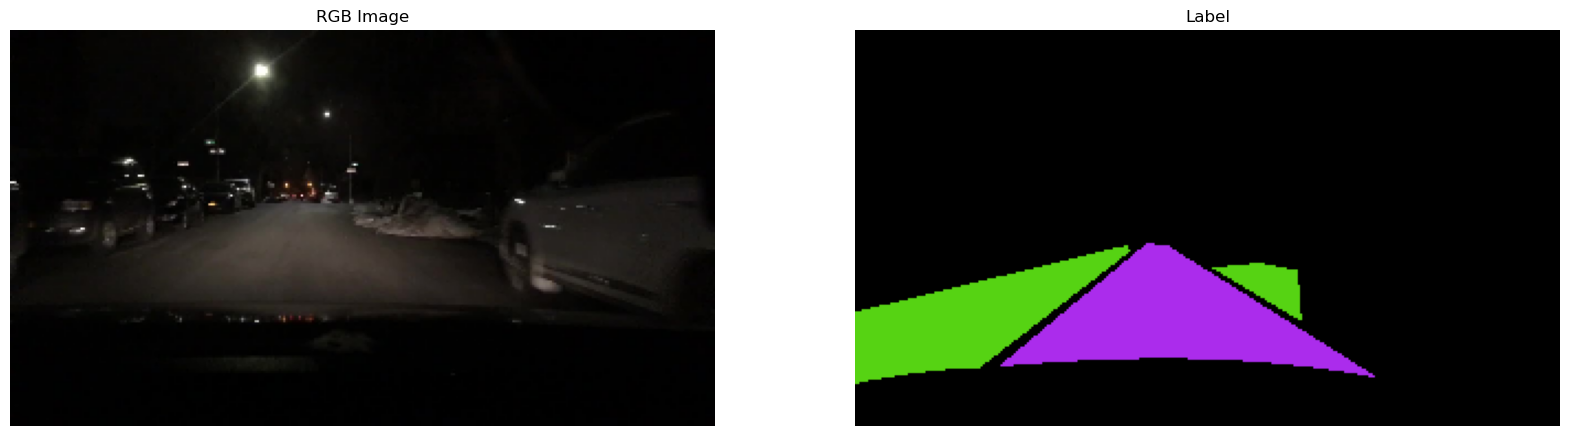

In [10]:
# plot sample image using defined color mappings
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(images[458]);
axes[0].set_title("RGB Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[labels[201]]);
axes[1].set_title("Label");
axes[1].axis('off');

### Datasets & DataLoaders

In [11]:
class BDD100k_dataset(Dataset):
    def __init__(self, images, labels, tf):
        self.images = images
        self.labels = labels
        self.tf = tf

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        rgb_image = self.images[index]
        if self.tf is not None:
            rgb_image = self.tf(rgb_image)

        # read label image and convert to torch tensor
        label_image  = torch.from_numpy(self.labels[index]).long()
        return rgb_image, label_image

In [12]:
preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [13]:
# Function to split data into train, validation and test sets
def get_datasets(images, labels):
    data = BDD100k_dataset(images, labels, tf=preprocess)
    total_count = len(data)
    train_count = int(0.7 * total_count)
    valid_count = int(0.2 * total_count)
    test_count = total_count - train_count - valid_count
    train_set, val_set, test_set = torch.utils.data.random_split(data,
                (train_count, valid_count, test_count), generator=torch.Generator().manual_seed(1))
    return train_set, val_set, test_set

In [14]:
def get_dataloaders(train_set, val_set, test_set):
    train_dataloader = DataLoader(train_set, batch_size=8,drop_last=True)
    val_dataloader   = DataLoader(val_set, batch_size=8)
    test_dataloader  = DataLoader(test_set, batch_size=8)
    return train_dataloader, val_dataloader, test_dataloader


In [15]:
train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


### Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


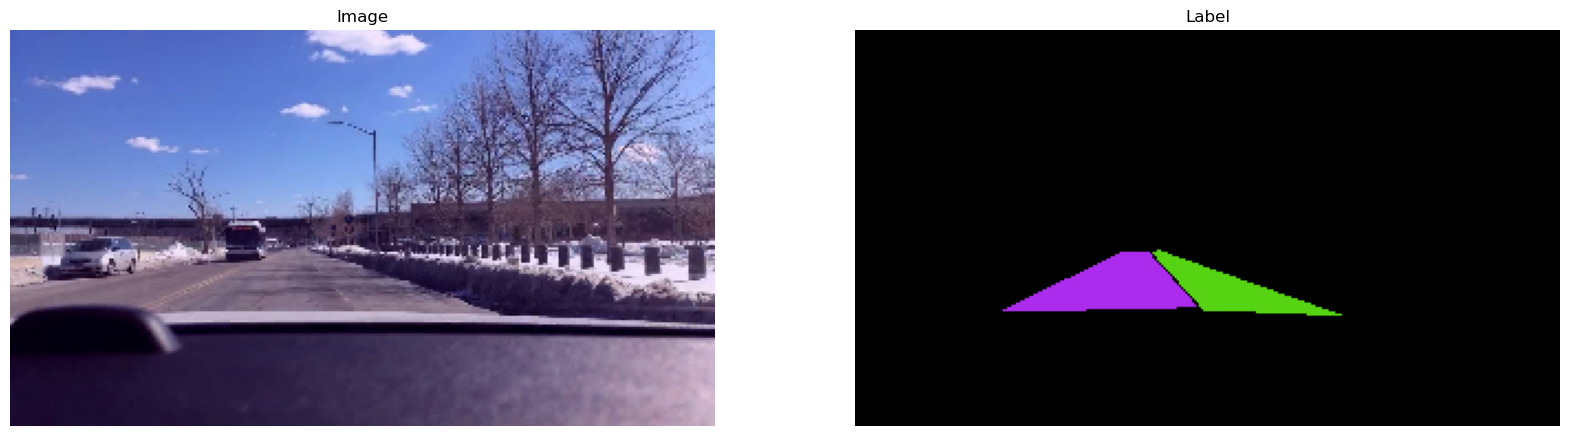

In [16]:
from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## UNet Encoder-Decoder
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Main elements:
* The Encoder
* The Decoder
* The Skip-Connections

In [17]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

In [18]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.ModuleList()

        # Double Convolution blocks
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Pass input image through Encoder blocks
        # and return outputs at each stage
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        return x, skip_connections


class UNetDecoder(nn.Module):
    def __init__(self, layer_channels):
        super(UNetDecoder, self).__init__()
        self.decoder = nn.ModuleList()

        # Decoder layer Double Convolution blocks
        # and upsampling blocks
        self.decoder = nn.ModuleList()
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels*2, num_channels))


    def forward(self, x, skip_connections):
        for idx in range(0, len(self.decoder), 2):
            # upsample output and reduce channels by 2
            x = self.decoder[idx](x)

            # if skip connection shape doesn't match, resize
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # concatenate and pass through double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        return x



class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()

        # Encoder and decoder modules
        self.encoder = UNetEncoder(in_channels, layer_channels)
        self.decoder = UNetDecoder(layer_channels)

        # conv layer to transition from encoder to decoder and
        # 1x1 convolution to reduce num channels to out_channels
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)

        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                # nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder blocks
        encoder_output, skip_connections = self.encoder(x)

        # transition between encoder and decoder
        x = self.bottleneck(encoder_output)

        # we need the last skip connection first
        # so reversing the list
        skip_connections = skip_connections[::-1]

        # Decoder blocks
        x = self.decoder(x, skip_connections)

        # final 1x1 conv to match input size
        return self.final_conv(x)

In [19]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Hyperparameters

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 5
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'UNet_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=3, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

In [21]:
output_path = "dataset"

Starting 1 epoch ...


  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\mayur\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 86/86 [00:24<00:00,  3.58it/s]


Epoch: 1, trainLoss:0.93043, validationLoss:0.76387, meanIoU: 0.45
Starting 2 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.66it/s]


Epoch: 2, trainLoss:0.52978, validationLoss:0.51320, meanIoU: 0.56
Starting 3 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.70it/s]


Epoch: 3, trainLoss:0.39424, validationLoss:0.52987, meanIoU: 0.59
Starting 4 epoch ...


100%|██████████| 86/86 [00:23<00:00,  3.59it/s]


Epoch: 4, trainLoss:0.33532, validationLoss:0.35521, meanIoU: 0.64
Starting 5 epoch ...


100%|██████████| 86/86 [00:14<00:00,  5.92it/s]


Epoch: 5, trainLoss:0.28110, validationLoss:0.33635, meanIoU: 0.65


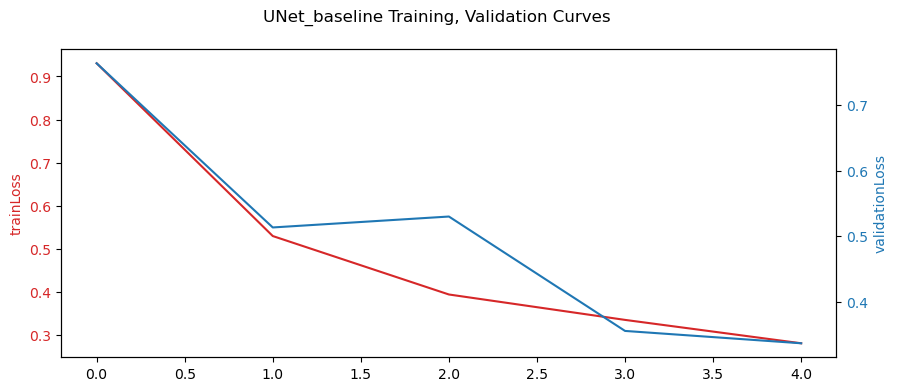

In [22]:
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

# Evaluation

In [23]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:07<00:00,  5.81it/s]


Model has 0.6587167439201148 mean IoU in test set


In [24]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


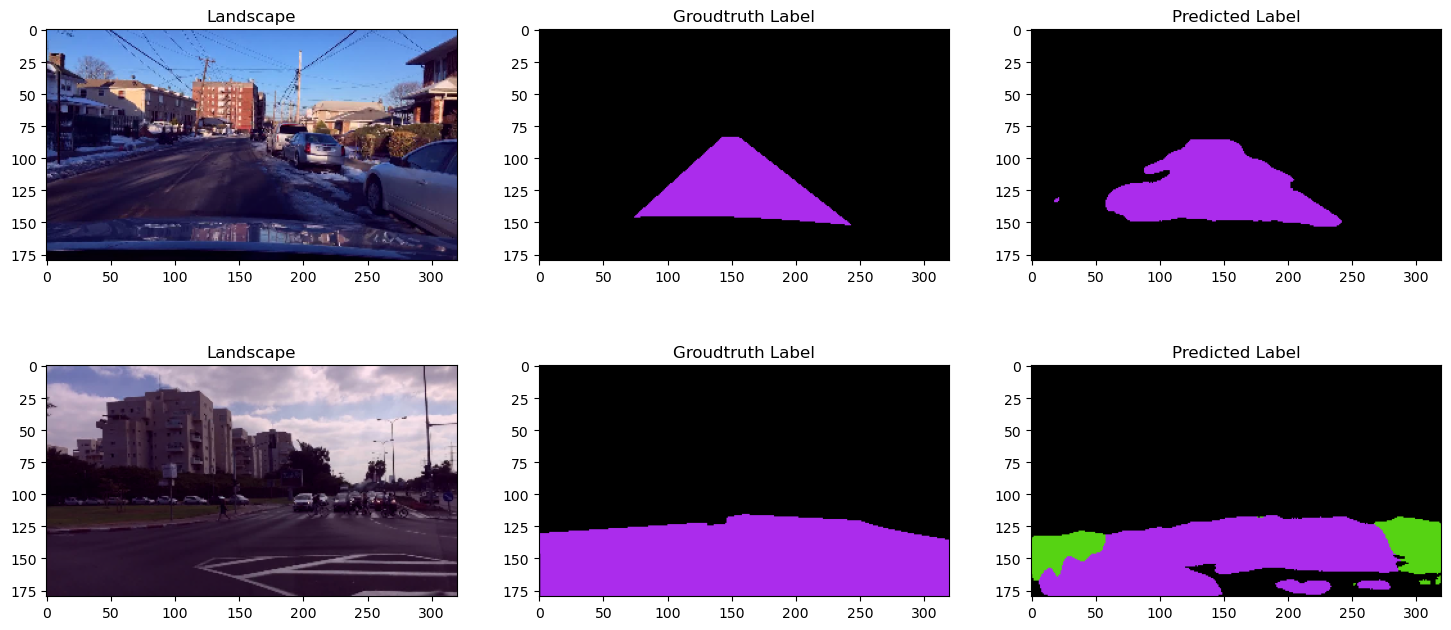

In [25]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

## Test on  video

In [26]:
from utils import predict_video
predict_video(model, "Unet5epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cuda", train_id_to_color)

100%|██████████| 1170/1170 [03:21<00:00,  5.79it/s]


In [29]:
output_path="weights/"
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))

<All keys matched successfully>

Unet on Stuttgart dataset

In [30]:
predict_video(model, "UnetHQ", "stuttgart_1024_512_360_640.avi", "segmentation", 640, 360, "cuda", train_id_to_color)

  0%|          | 0/599 [00:00<?, ?it/s]c:\Users\mayur\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 599/599 [00:42<00:00, 14.12it/s]
